In [1]:
import warnings
warnings.filterwarnings('ignore')

from bs4 import BeautifulSoup as bs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', 500)
import time
import requests
import random
from joblib import Parallel, delayed
import itertools
from tqdm import tqdm_notebook as tqdm
import re
from datetime import datetime
import locale
import ast
import os
from pandas import ExcelWriter

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  10 out of  24 | elapsed:    3.6s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done  11 out of  24 | elapsed:    3.8s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done  12 out of  24 | elapsed:    3.8s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  13 out of  24 | elapsed:    3.8s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  14 out of  24

  0%|          | 0/955 [00:00<?, ?it/s]

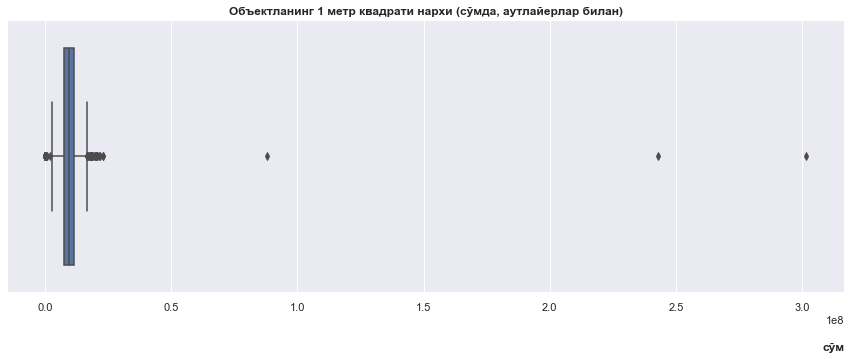

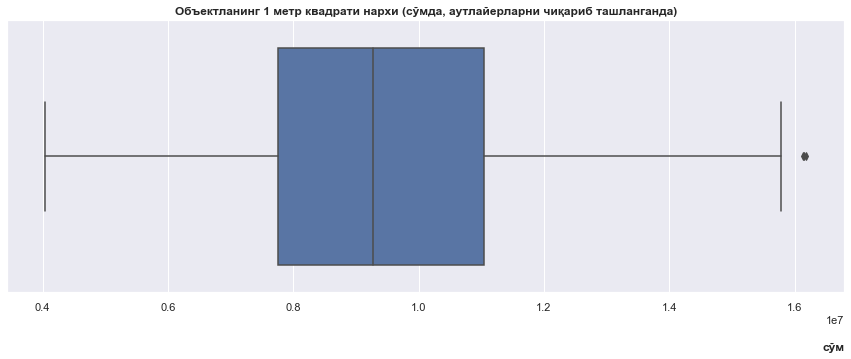

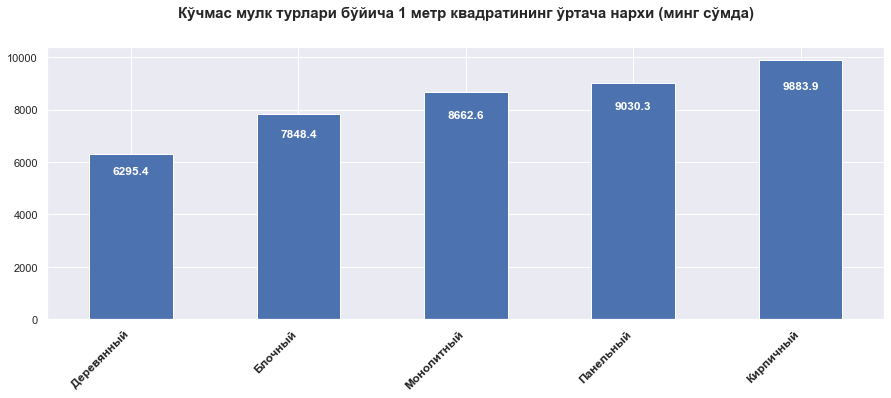

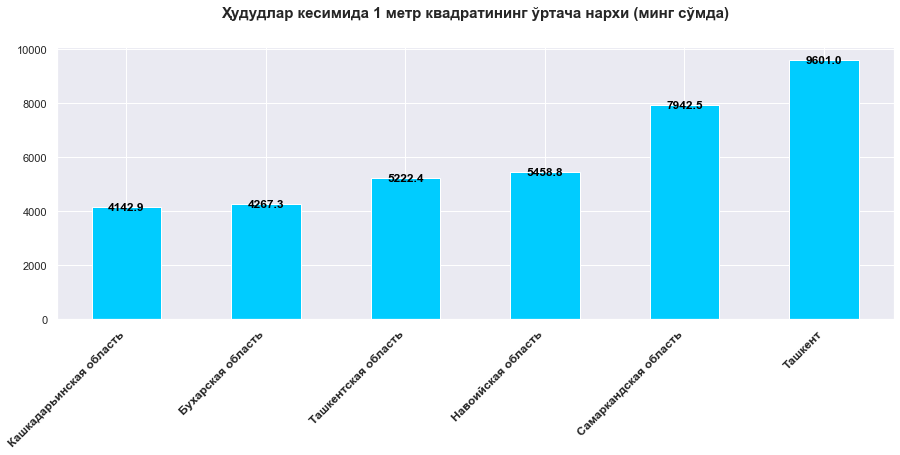

In [2]:
page = requests.get('https://www.olx.uz/nedvizhimost/kvartiry/prodazha/', verify=False)
soup = bs(page.content, 'html.parser')
string = soup.find_all('a')

string2 = soup.find_all(class_='item fleft')
for i in string2:
    aa = str(i.find('span'))
    last_page = int(aa[aa.index('<span>')+6:aa.index('</span>')])

urls = []
for url in string:
    urls.append(str(url.get('href')))
    
urls = list(map(str, urls))
urls = filter(lambda x: 'obyavlenie' in x, urls)
urls = list(urls)
            
def take_urls(i):
            page = requests.get(f'https://www.olx.uz/nedvizhimost/kvartiry/prodazha/?page={i}', verify=False)
            soup = bs(page.content, 'html.parser')
            string = soup.find_all('a')
            
            urls = []
            for url in string:
                urls.append(str(url.get('href')))
            
            urls = list(map(str, urls))
            urls = filter(lambda x: 'obyavlenie' in x, urls)
            urls = list(urls)
            urls = filter(lambda x: 'promoted' not in x, urls)
            urls = list(urls)
            return urls
'''
all_urls = []
for i in tqdm(np.arange(2, last_page+1)):
    all_urls.append(take_urls(i))
    '''
all_urls = Parallel(n_jobs=-1, verbose=last_page)(delayed(take_urls)(i) for i in np.arange(2, last_page+1))
all_urls = list(itertools.chain.from_iterable(all_urls))
all_urls = urls + all_urls

df = pd.DataFrame(columns=['source', 'url', 'date', 'oblast', 'shahar_tuman', 'price', 'price_currency', 'features', 'Описание'])
df.url = all_urls
df.source = 'olx.uz'
df.drop_duplicates(subset=['url'], inplace=True)
df.reset_index(drop=True, inplace=True)

today = datetime.today().strftime('%d.%m.%Y')

df.to_csv(f'D:/Oybek/Renta/oper/df1_{today}.csv', index=False)
df = pd.read_csv(f'D:/Oybek/Renta/oper/df1_{today}.csv')

#file_names = os.listdir('D:/Oybek/Renta/oper/')
#file_names = list(filter(lambda x: 'df1' in x, file_names))

#def read_csv_files(i):
#    return pd.read_csv('D:/Oybek/Renta/oper/' + i)

#df_list = Parallel(n_jobs=-1, verbose=len(file_names))(delayed(read_csv_files)(i) for i in file_names)
#df = pd.concat(df_list)
#df.drop_duplicates(subset=['url'], inplace=True)
#df.reset_index(drop=True, inplace=True)

def remove(a):
        return a.replace('\n', '')

def loop(index):
    url = df.iloc[index, 1]
    #headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.71 Safari/537.36'}
    try:
        page = requests.get(url, verify=False)
    except:
        time.sleep(random.randint(300, 388)/5)
        try:
            page = requests.get(url, verify=False)
        except:
            time.sleep(random.randint(300, 388)/5)
            page = requests.get(url, verify=False)
    #page = requests.get(url, verify=False)
    soup = bs(page.text, 'html.parser')
    
    #rate = [i/10 for i in range(10)]
    #time.sleep(random.choice(rate))
    
    try:
        date_of = soup.find_all(class_='css-19yf5ek')
        date_of = date_of[0].contents[0].split()
        
        RU_MONTH_VALUES = {
            'января': 1,
            'февраля': 2,
            'марта': 3,
            'апреля': 4,
            'мая': 5,
            'июня': 6,
            'июля': 7,
            'августа': 8,
            'сентября': 9,
            'октября': 10,
            'ноября': 11,
            'декабря': 12,
        }
        
        if date_of[0] == 'Сегодня':
            date_of = datetime.today().strftime('%d.%m.%Y')
        else:
            date_of = soup.find_all(class_='css-19yf5ek')
            date_of = date_of[0].contents[0].split()
            aa = RU_MONTH_VALUES[date_of[1]]
            date_of[1] = f'{aa}' 
            date_of = '.'.join(date_of[:3])
            date_of = datetime.strptime(date_of, '%d.%m.%Y').strftime('%d.%m.%Y')
    except (AttributeError, ValueError, IndexError):
        date_of = np.nan
    
    try:
        place = soup.find_all(class_='css-tyi2d1')
        oblast = place[-2].contents[0]
        oblast = oblast[oblast.index('-')+2:]
        shahar_tuman = place[-1].contents[0]
        shahar_tuman = shahar_tuman[shahar_tuman.index('-')+2:]
    except (AttributeError, ValueError, IndexError):
        oblast = np.nan
        shahar_tuman = np.nan
    
    try:
        string = soup.find_all(class_='css-xl6fe0-Text eu5v0x0')
        features = []
        for i in string:
            try:
                word = i.contents[0].contents[0]
            except (AttributeError, ValueError, IndexError):
                word = i.contents[0]
            features.append([word])
    except (AttributeError, ValueError, IndexError):
        features = np.nan
    
    try:
        Описание = soup.find_all(class_='css-g5mtbi-Text')
        Описание = Описание[0].contents
       
        try:
            no = Описание[1]
            Описание = list(filter(lambda x: x != no, Описание))
            Описание = list(map(remove, Описание))
        except (ValueError, IndexError):
            Описание = Описание
    except (AttributeError, ValueError, IndexError):
        Описание = np.nan
    
    try:
        price_string = soup.find_all(class_='css-okktvh-Text eu5v0x0')
        price = price_string[0].contents[0]
        price_currency = price_string[0].contents[-1]
    except (AttributeError, ValueError, IndexError):
        price = np.nan
        price_currency = np.nan
    
    #df_info = pd.DataFrame([[date_of, oblast, shahar_tuman, price, price_currency, features, Описание]], columns=['date', 'oblast', 'shahar_tumam', 'price', 'price_currency', 'features', 'Описание'])
    df.iloc[index, np.arange(2, 9)] = [date_of, oblast, shahar_tuman, price, price_currency, features, Описание] #df_info

#Parallel(n_jobs=-1, verbose=df.shape[0])(delayed(loop)(index) for index in range(df.shape[0]))

for index in tqdm(range(df.shape[0])):
    loop(index)
    #time.sleep(random.randint(10, 200)/100)

df.to_csv(f'D:/Oybek/Renta/oper/df1_raw_{today}.csv', index=False)
df = pd.read_csv(f'D:/Oybek/Renta/oper/df1_raw_{today}.csv')
#file_names = os.listdir('D:/Oybek/Renta/oper/')
#file_names = list(filter(lambda x: 'df1_raw_' in x, file_names))

#def read_csv_files(i):
 #   return pd.read_csv('D:/Oybek/Renta/oper/' + i)

#df_list = Parallel(n_jobs=-1, verbose=len(file_names))(delayed(read_csv_files)(i) for i in file_names)
#df = pd.concat(df_list)
df.drop_duplicates(subset=['url'], inplace=True)
df.reset_index(drop=True, inplace=True)    
    
def take_df_feature(feature):
    #feature = df.iloc[index, 7]
    feature = ast.literal_eval(feature)
    try:
        feature[0]
        headers = list(filter(lambda x: ':' in x[0], feature))
        headers2 = ['entity'] + list(map(lambda x: x[0][:x[0].index(':')], headers))
        entity_value = list(filter(lambda x: ':' not in x[0], feature))[0]
        values = entity_value + list(map(lambda x: x[0][x[0].index(':')+2:], headers))
        df_feature = pd.DataFrame([values], columns=headers2)
    except (IndexError, ValueError, TypeError):
        df_feature = pd.DataFrame(['Yes'], columns=['Deleted'])
        
    return df_feature
    
#big_df_feature_list = Parallel(n_jobs=-1, verbose=df.shape[0])(delayed(take_df_feature)(index) for index in range(df.shape[0]))
'''
for index in range(df.shape[0]):
    print(index)
    take_df_feature(index) '''
df['feature_dfs'] = df['features'].apply(take_df_feature)
big_df_feature_list = pd.concat(df['feature_dfs'].to_list())
#big_df_feature_list = pd.concat(big_df_feature_list)
big_df_feature_list.reset_index(drop=True, inplace=True)
df.drop(columns=['feature_dfs'], inplace=True)
df2 = pd.concat([df, big_df_feature_list], axis=1)
df2.dropna(subset=['Общая площадь'], inplace=True)
df2.insert(12, 'area', df2.loc[:, 'Общая площадь'].apply(lambda x: x[:-3].replace(' ', '')).astype(float))
df2['price'] = df2.loc[:, 'price'].apply(lambda x: x.replace(' ', '')).astype(float)

#take exchange rate:
page = requests.get('https://cbu.uz/oz/', verify=False)
soup = bs(page.content, 'html.parser')
kurs = soup.find_all(class_='exchange__item_value')
exch_rate = float(kurs[0].contents[1][kurs[0].contents[1].index('=')+2:])

def convert(x):
    if x == 'у.е.':
        return exch_rate
    else:
        return 1
today = datetime.today().strftime('%d.%m.%Y')
df2.insert(6, 'in_soum', df2.loc[:, 'price_currency'].apply(convert)*df2.loc[:, 'price'])

def func_price_per_m2(x,y):
    if x*y > 20000000:
        return x/y
    else:
            return x
    
        
price_per_m2 = df2[['in_soum', 'area']].apply(lambda x: func_price_per_m2(x['in_soum'], x['area']), axis=1)
df2.insert(7, 'price_per_m2', price_per_m2)
df2.sort_values(by=['price_per_m2'], ascending=False, inplace=True)
df2.index = np.arange(1, len(df2.index)+1)

Q1, Q3 = df2['price_per_m2'].quantile([0.25, 0.75])
IQR = Q3 - Q1
low = Q1 - IQR*1.5
high = Q3 + IQR*1.5
df3 = df2.query('{low}<price_per_m2<{high}'.format(low=low, high=high))
df3['Тип строения'] = df3['Тип строения'].apply(str).apply(lambda x: x.split(', '))
df3.index = np.arange(1, len(df3.index)+1)

Q1, Q3 = df2['price_per_m2'].quantile([0.05, 0.95])
IQR = Q3 - Q1
low = Q1
high = Q3
df4 = df2.query('{low}<price_per_m2<{high}'.format(low=low, high=high))
df4['Тип строения'] = df4['Тип строения'].apply(str).apply(lambda x: x.split(', '))
df4.index = np.arange(1, len(df4.index)+1)

type_of_rent = df4['Тип строения'].to_list()
type_of_rent = list(itertools.chain.from_iterable(type_of_rent))
type_of_rent = pd.Series(type_of_rent)
df_mean_per_type = pd.DataFrame(type_of_rent.unique(), columns=['type'])
df_mean_per_type['price_per_m2_per_type'] = np.nan
def find_mean(i):
    return df4[df4['Тип строения'].apply(lambda x: ''.join(x)).str.contains(i, regex=False)\
              ]['price_per_m2'].mean()
if 'nan' in df_mean_per_type.type.to_list():
    df_mean_per_type.drop(df_mean_per_type[df_mean_per_type.type == 'nan'].index, inplace=True)
df_mean_per_type['price_per_m2_per_type'] = df_mean_per_type.type.apply(find_mean)
df_mean_per_type.sort_values(by=['price_per_m2_per_type'], ascending=True, inplace=True)
df_mean_per_type.reset_index(drop=True, inplace=True)
df_mean_per_type2 = df_mean_per_type.loc[~(df_mean_per_type.type == 'Другое')]
df_mean_per_type3 = pd.concat([df_mean_per_type2, df_mean_per_type.loc[df_mean_per_type.type == 'Другое']])
df_mean_per_type3.index = np.arange(1, len(df_mean_per_type3.index)+1)
df_mean_per_type3['price_per_m2_per_type_rounded'] = df_mean_per_type3['price_per_m2_per_type'].apply(lambda x: round(x/1000, 1))

month_dict = {'12': 'Декабрь', '11' : 'Ноябрь', '10' : 'Октябрь', '09' : 'Сентябрь', '08' : 'Август', '07' : 'Июль',\
             '06' : 'Июнь', '05' : 'Май', '04' : 'Апрель', '03' : 'Март', '02' : 'Февраль', '01' : 'Январь',}
month_name = month_dict[today[3:5]]

df_mean_per_region = df4[['oblast', 'price_per_m2']].groupby(['oblast']).mean()
df_mean_per_region.reset_index(inplace=True)
df_mean_per_region.columns = ['oblast', 'price_per_m2_per_region']
df_mean_per_region.sort_values(by=['price_per_m2_per_region'], ascending=True, inplace=True)
df_mean_per_region.reset_index(drop=True, inplace=True)
df_mean_per_region['price_per_m2_per_region_rounded'] = df_mean_per_region['price_per_m2_per_region'].apply(lambda x: round(x/1000, 1))


sheet_names = ['df_raw', 'df_no_outliers', 'df_no_outliers2',  'by_type', 'by_region']
def save_xls(list_dfs, xls_path):
    with ExcelWriter(xls_path) as writer:
        for n, df in enumerate(list_dfs):
            df.to_excel(writer, sheet_names[n])
        writer.save()
list_dfs = [df2, df3, df4, df_mean_per_type3, df_mean_per_region]
xls_path = f'D:/Oybek/Renta/Sotiladigan/{today}.xlsx'
save_xls(list_dfs, xls_path)


sns.set(rc={'figure.figsize':(15, 5)})
ax = sns.boxplot(x = df2['price_per_m2'])
ax.set_xlabel('сўм', labelpad=30, loc='right', fontweight='bold')
ax.set_title('Объектланинг 1 метр квадрати нархи (сўмда, аутлайерлар билан)', fontweight='bold')
plt.show()
ax = sns.boxplot(x = df4['price_per_m2'])
ax.set_xlabel('сўм', labelpad=30, loc='right', fontweight='bold')
ax.set_title('Объектланинг 1 метр квадрати нархи (сўмда, аутлайерларни чиқариб ташланганда)', fontweight='bold')
plt.show()

'''
tarjima = {'Склады': 'Омборхоналар ва сақлаш иншоотлари', 
           'Помещения промышленного назначения': 'Ишлаб чиқариш унун бино-иншоотлар',
          'Отдельно стоящие здания': 'Алоҳида қурилган бино',
          'Часть здания': 'Бинонинг бир қисми',
          'Помещения свободного назначения': 'Эркин фойдаланиш мумкин бўлган бинолар',
          'Базы отдыха': 'Дам олиш масканлари',
           'МАФ (малая архитектурная форма)': 'Ихчам архитектурали бино',
          'Офисы': 'Офислар',
          'Рестораны/кафе/бары': 'Ресторан/кафе/барлар',
           'Магазины/бутики': 'Савдо дўконлари ва бутиклар',
              'Салоны': 'Салонлар',
          'Другое': 'Бошқалар',}
def translate(i):
    return tarjima[i]
'''
ax = df_mean_per_type3['price_per_m2_per_type_rounded'].plot.bar()
ax.set_xticklabels(labels=df_mean_per_type3['type'], rotation=45, horizontalalignment='right', fontweight='bold', fontsize=12)
ax.set_title('Кўчмас мулк турлари бўйича 1 метр квадратининг ўртача нархи (минг сўмда)', fontweight='bold', pad=30, fontsize=15)
for i, patch in enumerate(ax.patches):
    x, y = patch.get_xy()
    x += patch.get_width() / 2
    y += patch.get_height()*0.9
    ax.annotate(df_mean_per_type3['price_per_m2_per_type_rounded'][i+1], (x, y), ha='center', va='center', c='white', fontweight='bold')
plt.show()

'''
tarjima = {'Каракалпакстан': 'Қорақалпоғистон',
 'Наманганская область ': 'Наманган',
 'Самаркандская область': 'Самарқанд',
 'Хорезмская область': 'Хоразм',
 'Кашкадарьинская область': 'Қашқадарё',
 'Бухарская область': 'Бухоро',
 'Ташкентская область': 'Тошкент вилояти',
 'Ферганская область': 'Фарғона',
 'Навоийская область': 'Навоий',
 'Андижанская область ': 'Андижон',
 'Джизакская область ': 'Жиззах',
 'Ташкент': 'Тошкент шаҳри',
          'Сырдарьинская область': 'Cирдарё вилояти',
          'Сурхандарьинская область': 'Сурхондарё вилояти'}
def translate(i):
    return tarjima[i]
'''

ax = df_mean_per_region['price_per_m2_per_region_rounded'].plot.bar(color='#00ccff')
ax.set_xticklabels(labels=df_mean_per_region['oblast'], rotation=45, horizontalalignment='right', fontweight='bold', fontsize=12)
ax.set_title('Ҳудудлар кесимида 1 метр квадратининг ўртача нархи (минг сўмда)', fontweight='bold', pad=30, fontsize=15)
for i, patch in enumerate(ax.patches):
    x, y = patch.get_xy()
    x += patch.get_width() / 2
    y += patch.get_height() +2#*0.9
    ax.annotate(df_mean_per_region['price_per_m2_per_region_rounded'][i], (x, y), ha='center', va='center', c='black', fontweight='bold')
plt.show()

In [3]:
def read_excel_file(t):
    return pd.read_excel('D:/Oybek/Renta/Sotiladigan/' + t + '.xlsx', sheet_name='df_no_outliers2')['price_per_m2'].mean()

file_list = list(filter(lambda x: '~$' not in x, os.listdir('D:/Oybek/Renta/Sotiladigan/')))
mean_df = pd.DataFrame(list(map(lambda x: x[:-5], file_list)), columns=['date'])
mean_df['mean_per_day'] = mean_df['date'].apply(read_excel_file)

In [4]:
mean_df

,date,mean_per_day
0,10.01.2022,8.716086e+06
1,17.02.2022,9.637233e+06
2,19.01.2022,9.205578e+06
3,20.01.2022,8.949369e+06
4,21.01.2022,8.835142e+06
5,23.02.2022,9.467439e+06


In [3]:
df = pd.read_excel('D:/Oybek/Renta/Oylik/23.12.2021.xlsx', sheet_name='df_raw')
type_of_rent = df['oblast']#.to_list()
type_of_rent.unique()

array(['Ташкент', 'Бухарская область', 'Самаркандская область',
       'Кашкадарьинская область', 'Каракалпакстан', 'Ферганская область',
       'Андижанская область ', 'Ташкентская область',
       'Навоийская область', 'Джизакская область ', 'Хорезмская область',
       'Наманганская область '], dtype=object)

In [4]:
df['price_per_m2'].max()/10

1847393.162393162

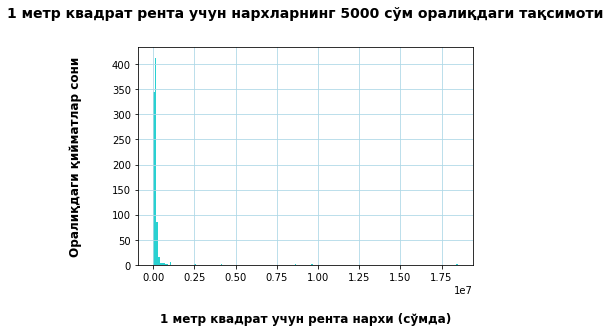

In [8]:
#df.hist(column=['price_per_m2'], bins=100,)
ax = plt.axes()
plt.hist(df['price_per_m2'], bins=round(df['price_per_m2'].max()/100000), color='#11cccc', alpha=.9, animated=True,)
ax.set(facecolor = "white")
plt.grid(True, c='lightblue')
plt.ylabel('Оралиқдаги қийматлар сони', labelpad=30, fontweight='bold', fontsize=12)
plt.xlabel('1 метр квадрат учун рента нархи (сўмда)', labelpad=30, fontweight='bold', fontsize=12)
plt.title('1 метр квадрат рента учун нархларнинг 5000 сўм оралиқдаги тақсимоти', pad=30, fontweight='bold', fontsize=14)
plt.show()

In [24]:
df['price_per_m2'].max()

288193.3333333333

In [7]:
df[['oblast', 'price_per_m2']].groupby(['oblast']).mean()

,price_per_m2
oblast,
Андижанская область,86458.000000
Бухарская область,50811.047273
Джизакская область,93750.000000
Каракалпакстан,4934.210526
Кашкадарьинская область,36912.386364
Навоийская область,78143.880208
Наманганская область,13509.062500
Самаркандская область,30254.452139
Ташкент,120446.683333


In [37]:
df_mean_per_region

,price_per_m2
0,86458.000000
1,50811.047273
2,93750.000000
3,4934.210526
4,36912.386364
5,78143.880208
6,13509.062500
7,30254.452139
8,120446.683333
9,59706.439887


In [8]:
df_mean_per_region = df[['oblast', 'price_per_m2']].groupby(['oblast']).mean()
df_mean_per_region.reset_index(inplace=True)
df_mean_per_region.columns = ['oblast', 'price_per_m2_per_region']
df_mean_per_region.sort_values(by=['price_per_m2_per_region'], ascending=True, inplace=True)
df_mean_per_region.reset_index(drop=True, inplace=True)
df_mean_per_region['price_per_m2_per_region_rounded'] = df_mean_per_region['price_per_m2_per_region'].apply(lambda x: round(x/1000, 1))

In [9]:
df_mean_per_region

,oblast,price_per_m2_per_region,price_per_m2_per_region_rounded
0,Каракалпакстан,4934.210526,4.9
1,Наманганская область,13509.062500,13.5
2,Самаркандская область,30254.452139,30.3
3,Хорезмская область,32993.356036,33.0
4,Кашкадарьинская область,36912.386364,36.9
5,Бухарская область,50811.047273,50.8
6,Ташкентская область,59706.439887,59.7
7,Ферганская область,68358.387731,68.4
8,Навоийская область,78143.880208,78.1
9,Андижанская область,86458.000000,86.5


In [42]:
df_mean_per_region.oblast.to_list()

['Каракалпакстан',
 'Наманганская область ',
 'Самаркандская область',
 'Хорезмская область',
 'Кашкадарьинская область',
 'Бухарская область',
 'Ташкентская область',
 'Ферганская область',
 'Навоийская область',
 'Андижанская область ',
 'Джизакская область ',
 'Ташкент']

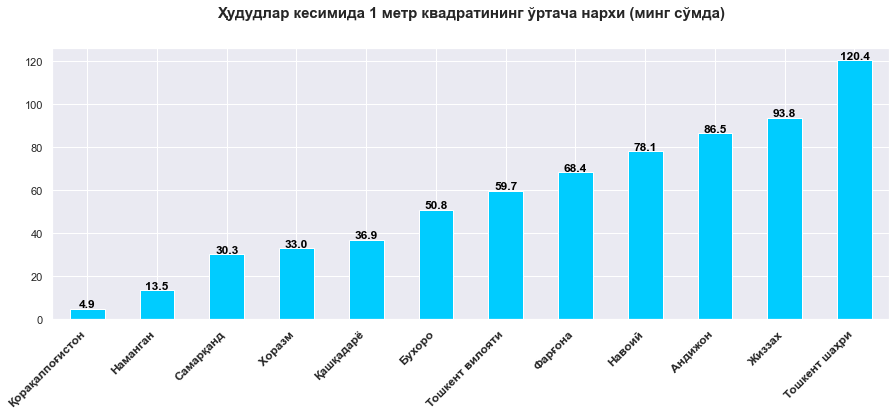

In [10]:
tarjima = {'Каракалпакстан': 'Қорақалпоғистон',
 'Наманганская область ': 'Наманган',
 'Самаркандская область': 'Самарқанд',
 'Хорезмская область': 'Хоразм',
 'Кашкадарьинская область': 'Қашқадарё',
 'Бухарская область': 'Бухоро',
 'Ташкентская область': 'Тошкент вилояти',
 'Ферганская область': 'Фарғона',
 'Навоийская область': 'Навоий',
 'Андижанская область ': 'Андижон',
 'Джизакская область ': 'Жиззах',
 'Ташкент': 'Тошкент шаҳри',
          'Сырдарьинская область': 'Тошкент шаҳри',
          'Сурхандарьинская область': 'Тошкент шаҳри'}
def translate(i):
    return tarjima[i]

ax = df_mean_per_region['price_per_m2_per_region_rounded'].plot.bar(color='#00ccff')
ax.set_xticklabels(labels=df_mean_per_region['oblast'].apply(translate), rotation=45, horizontalalignment='right', fontweight='bold', fontsize=12)
ax.set_title('Ҳудудлар кесимида 1 метр квадратининг ўртача нархи (минг сўмда)', fontweight='bold', pad=30, fontsize=15)
for i, patch in enumerate(ax.patches):
    x, y = patch.get_xy()
    x += patch.get_width() / 2
    y += patch.get_height() +2#*0.9
    ax.annotate(df_mean_per_region['price_per_m2_per_region_rounded'][i], (x, y), ha='center', va='center', c='black', fontweight='bold')
plt.show()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.0s finished


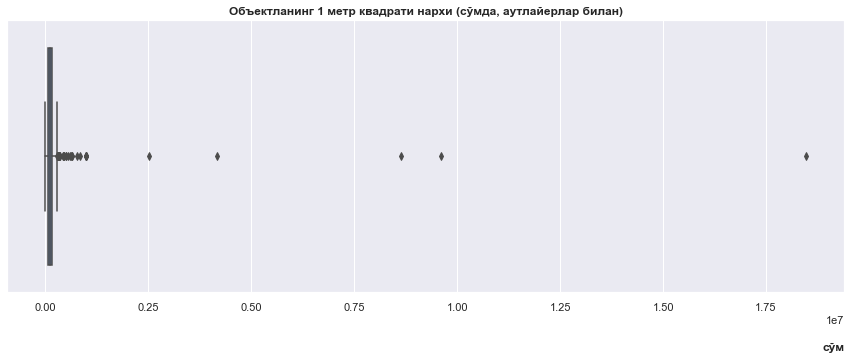

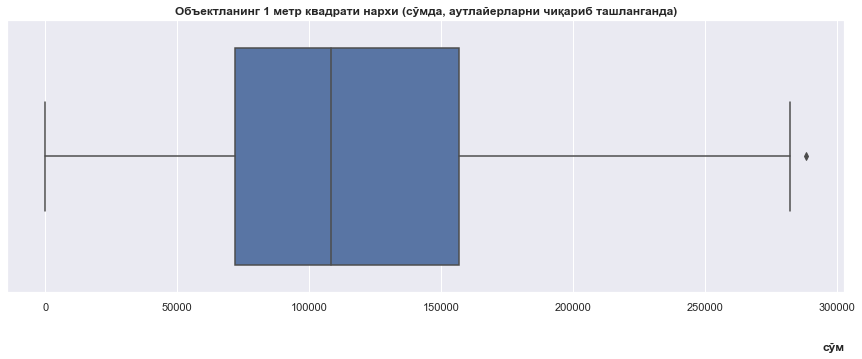

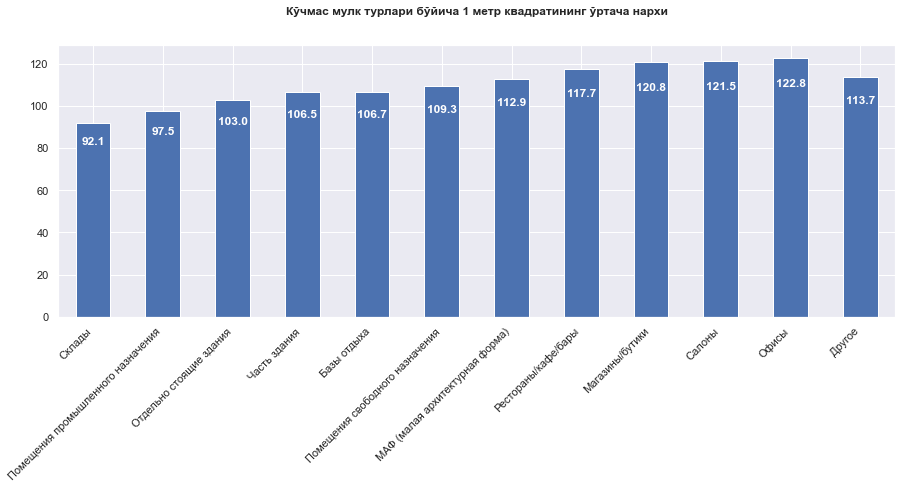

In [29]:
sns.set(rc={'figure.figsize':(15, 5)})
ax = sns.boxplot(x = df2['price_per_m2'])
ax.set_xlabel('сўм', labelpad=30, loc='right', fontweight='bold')
ax.set_title('Объектланинг 1 метр квадрати нархи (сўмда, аутлайерлар билан)', fontweight='bold', size=15, pad=30)
plt.show()
ax = sns.boxplot(x = df3['price_per_m2'])
ax.set_xlabel('сўм', labelpad=30, loc='right', fontweight='bold')
ax.set_title('Объектланинг 1 метр квадрати нархи (сўмда, аутлайерларни чиқариб ташланганда)', fontweight='bold', size=15, pad=30)
plt.show()

ax = df_mean_per_type3['price_per_m2_per_type_rounded'].plot.bar()
ax.set_xticklabels(labels=df_mean_per_type3['type'], rotation=45, horizontalalignment='right', fontweight='bold', size=13)
ax.set_title('Кўчмас мулк турлари бўйича 1 метр квадратининг ўртача нархи', fontweight='bold', size=15, pad=30)
for i, patch in enumerate(ax.patches):
    x, y = patch.get_xy()
    x += patch.get_width() / 2
    y += patch.get_height()*0.9
    ax.annotate(df_mean_per_type3['price_per_m2_per_type_rounded'][i+1], (x, y), ha='center', va='center', c='white', fontweight='bold', size=13)
plt.show()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


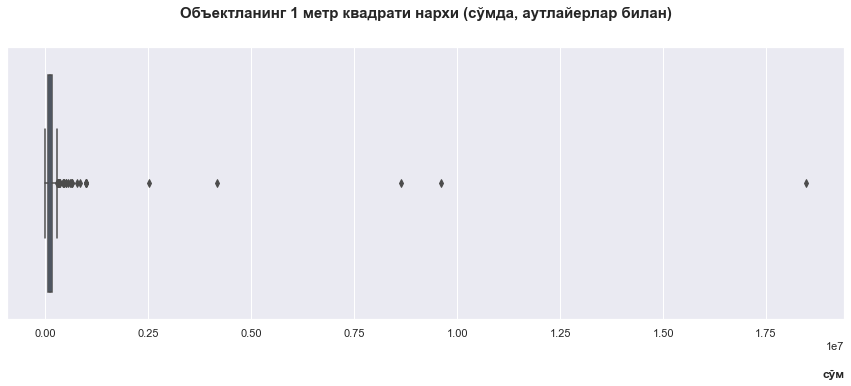

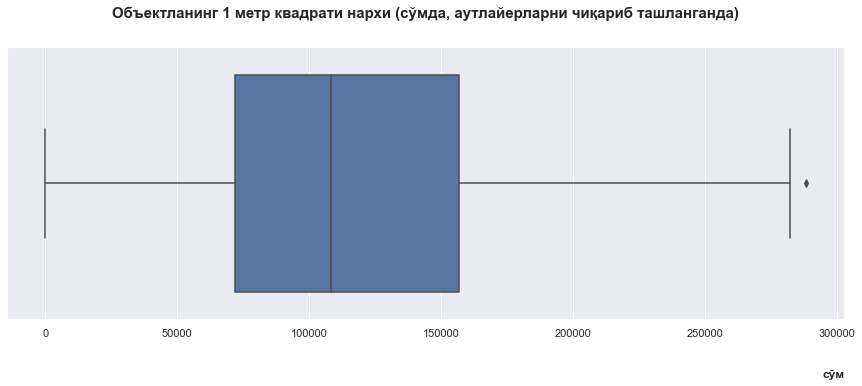

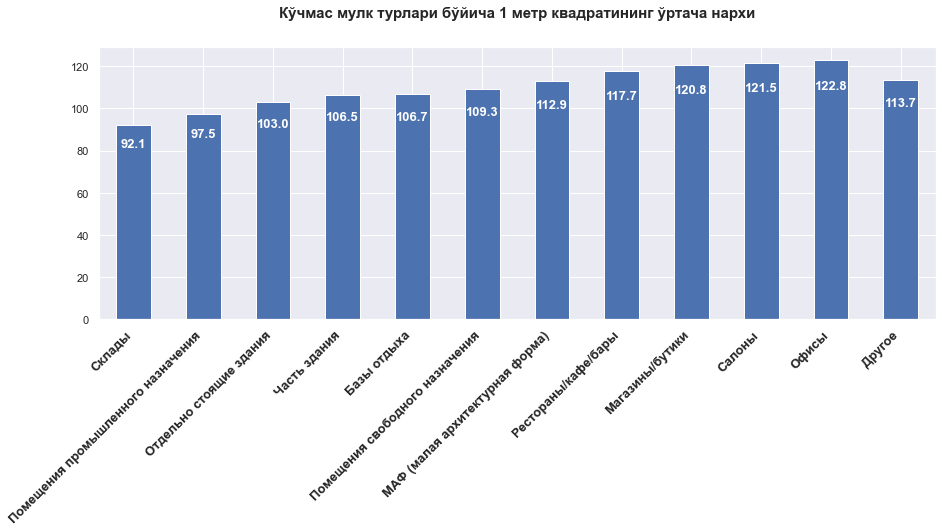

In [32]:
file_names = os.listdir('D:/Oybek/Renta/oper/')
file_names = list(filter(lambda x: 'df1_raw_' in x, file_names))

def read_csv_files(i):
    return pd.read_csv('D:/Oybek/Renta/oper/' + i)

df_list = Parallel(n_jobs=-1, verbose=len(file_names))(delayed(read_csv_files)(i) for i in file_names)
df = pd.concat(df_list)
df.drop_duplicates(subset=['url'], inplace=True)
df.reset_index(drop=True, inplace=True)    
    
def take_df_feature(feature):
    #feature = df.iloc[index, 7]
    feature = ast.literal_eval(feature)
    try:
        feature[0]
        headers = list(filter(lambda x: ':' in x[0], feature))
        headers2 = ['entity'] + list(map(lambda x: x[0][:x[0].index(':')], headers))
        entity_value = list(filter(lambda x: ':' not in x[0], feature))[0]
        values = entity_value + list(map(lambda x: x[0][x[0].index(':')+2:], headers))
        df_feature = pd.DataFrame([values], columns=headers2)
    except (IndexError, ValueError, TypeError):
        df_feature = pd.DataFrame(['Yes'], columns=['Deleted'])
        
    return df_feature
    
#big_df_feature_list = Parallel(n_jobs=-1, verbose=df.shape[0])(delayed(take_df_feature)(index) for index in range(df.shape[0]))
'''
for index in range(df.shape[0]):
    print(index)
    take_df_feature(index) '''
df['feature_dfs'] = df['features'].apply(take_df_feature)
big_df_feature_list = pd.concat(df['feature_dfs'].to_list())
#big_df_feature_list = pd.concat(big_df_feature_list)
big_df_feature_list.reset_index(drop=True, inplace=True)
df.drop(columns=['feature_dfs'], inplace=True)
df2 = pd.concat([df, big_df_feature_list], axis=1)
df2.dropna(subset=['Общая площадь'], inplace=True)
df2.insert(12, 'area', df2.loc[:, 'Общая площадь'].apply(lambda x: x[:-3].replace(' ', '')).astype(float))
df2['price'] = df2.loc[:, 'price'].apply(lambda x: x.replace(' ', '')).astype(float)

#take exchange rate:
page = requests.get('https://cbu.uz/oz/', verify=False)
soup = bs(page.content, 'html.parser')
kurs = soup.find_all(class_='exchange__item_value')
exch_rate = float(kurs[0].contents[1][kurs[0].contents[1].index('=')+2:])

def convert(x):
    if x == 'у.е.':
        return exch_rate
    else:
        return 1
today = datetime.today().strftime('%d.%m.%Y')
df2.insert(6, 'in_soum', df2.loc[:, 'price_currency'].apply(convert)*df2.loc[:, 'price'])

def func_price_per_m2(x,y):
    if x*y > 10000000:
        if x > 1000000:
            return x/y
        else:
            return x
    else:
        if x <=1000000:
            return x
        else:
            return x/y
        
price_per_m2 = df2[['in_soum', 'area']].apply(lambda x: func_price_per_m2(x['in_soum'], x['area']), axis=1)
df2.insert(7, 'price_per_m2', price_per_m2)
df2.sort_values(by=['price_per_m2'], ascending=False, inplace=True)
df2.index = np.arange(1, len(df2.index)+1)

Q1, Q3 = df2['price_per_m2'].quantile([0.25, 0.75])
IQR = Q3 - Q1
low = Q1  - IQR*1.5
high = Q3 + IQR*1.5
df3 = df2.query('{low}<price_per_m2<{high}'.format(low=low, high=high))
df3['Тип недвижимости'] = df3['Тип недвижимости'].apply(str).apply(lambda x: x.split(', '))
df3.index = np.arange(1, len(df3.index)+1)

type_of_rent = df3['Тип недвижимости'].to_list()
type_of_rent = list(itertools.chain.from_iterable(type_of_rent))
type_of_rent = pd.Series(type_of_rent)
df_mean_per_type = pd.DataFrame(type_of_rent.unique(), columns=['type'])
df_mean_per_type['price_per_m2_per_type'] = np.nan
def find_mean(i):
    return df3[df3['Тип недвижимости'].apply(lambda x: ''.join(x)).str.contains(i, regex=False)\
              ]['price_per_m2'].mean()
if 'nan' in df_mean_per_type.type.to_list():
    df_mean_per_type.drop(df_mean_per_type[df_mean_per_type.type == 'nan'].index, inplace=True)
df_mean_per_type['price_per_m2_per_type'] = df_mean_per_type.type.apply(find_mean)
df_mean_per_type.sort_values(by=['price_per_m2_per_type'], ascending=True, inplace=True)
df_mean_per_type.reset_index(drop=True, inplace=True)
df_mean_per_type2 = df_mean_per_type.loc[~(df_mean_per_type.type == 'Другое')]
df_mean_per_type3 = pd.concat([df_mean_per_type2, df_mean_per_type.loc[df_mean_per_type.type == 'Другое']])
df_mean_per_type3.index = np.arange(1, len(df_mean_per_type3.index)+1)
df_mean_per_type3['price_per_m2_per_type_rounded'] = df_mean_per_type3['price_per_m2_per_type'].apply(lambda x: round(x/1000, 1))

month_dict = {'12': 'Декабрь', '11' : 'Ноябрь', '10' : 'Октябрь', '09' : 'Сентябрь', '08' : 'Август', '07' : 'Июль',\
             '06' : 'Июнь', '05' : 'Май', '04' : 'Апрель', '03' : 'Март', '11' : 'Февраль', '11' : 'Январь',}
month_name = month_dict[today[3:5]]

sheet_names = ['df_raw', 'df_no_outliers', 'by_type']
def save_xls(list_dfs, xls_path):
    with ExcelWriter(xls_path) as writer:
        for n, df in enumerate(list_dfs):
            df.to_excel(writer, sheet_names[n])
        writer.save()
list_dfs = [df2, df3, df_mean_per_type3]
xls_path = f'D:/Oybek/Renta/Oylik/{month_name}____.xlsx'
save_xls(list_dfs, xls_path)


sns.set(rc={'figure.figsize':(15, 5)})
ax = sns.boxplot(x = df2['price_per_m2'])
ax.set_xlabel('сўм', labelpad=30, loc='right', fontweight='bold')
ax.set_title('Объектланинг 1 метр квадрати нархи (сўмда, аутлайерлар билан)', fontweight='bold', size=15, pad=30)
plt.show()
ax = sns.boxplot(x = df3['price_per_m2'])
ax.set_xlabel('сўм', labelpad=30, loc='right', fontweight='bold')
ax.set_title('Объектланинг 1 метр квадрати нархи (сўмда, аутлайерларни чиқариб ташланганда)', fontweight='bold', size=15, pad=30)
plt.show()

ax = df_mean_per_type3['price_per_m2_per_type_rounded'].plot.bar()
ax.set_xticklabels(labels=df_mean_per_type3['type'], rotation=45, horizontalalignment='right', fontweight='bold', size=13)
ax.set_title('Кўчмас мулк турлари бўйича 1 метр квадратининг ўртача нархи', fontweight='bold', size=15, pad=30)
for i, patch in enumerate(ax.patches):
    x, y = patch.get_xy()
    x += patch.get_width() / 2
    y += patch.get_height()*0.9
    ax.annotate(df_mean_per_type3['price_per_m2_per_type_rounded'][i+1], (x, y), ha='center', va='center', c='white', fontweight='bold', size=13)
plt.show()

In [32]:
%time
feature = df.iloc[0, 7]
#feature = ast.literal_eval(feature)

try:
    feature[0]
    headers = list(filter(lambda x: ':' in x[0], feature))
    headers2 = ['entity'] + list(map(lambda x: x[0][:x[0].index(':')], headers))
    entity_value = list(filter(lambda x: ':' not in x[0], feature))[0]
    values = entity_value + list(map(lambda x: x[0][x[0].index(':')+2:], headers))
    df_feature = pd.DataFrame([values], columns=headers2)
except (IndexError, ValueError):
        df_feature = pd.DataFrame(['Yes'], columns=['Deleted'])

Wall time: 0 ns


In [26]:
df_feature1 = df_feature.copy()

In [33]:
df_feature2 = df_feature.copy()

In [34]:
df_feature2

,entity,Тип недвижимости,Общая площадь,Полезная площадь,Расположение,Этаж,Этажность дома,Высота потолков,Ремонт,Наличие парковки,Комиссионные
0,Бизнес,"Магазины/бутики, Салоны, Офисы, Склады, Помещения свободного назначения",20 м²,20,Жилой дом,1,4,2,Средний,Да,Нет


In [35]:
pd.concat([df_feature1, df_feature2])

,entity,Тип недвижимости,Общая площадь,Этаж,Ремонт,Наличие парковки,Комиссионные,Полезная площадь,Расположение,Этажность дома,Высота потолков
0,Бизнес,Магазины/бутики,50 м²,1,Требует ремонта,Да,Да,NaN,NaN,NaN,NaN
0,Бизнес,"Магазины/бутики, Салоны, Офисы, Склады, Помещения свободного назначения",20 м²,1,Средний,Да,Нет,20,Жилой дом,4,2


In [16]:
df

,source,url,date,oblast,shahar_tuman,price,price_currency,features,Описание
0,olx.uz,https://www.olx.uz/d/obyavlenie/sdaetsya-pomeschenie-pod-lyuboy-vid-deyatelnosti-ID2GDPR.html#c1c0e14c53;promoted,22.12.2021,Ташкент,Юнусабадский район,200,у.е.,"[[Бизнес], [Тип недвижимости: Магазины/бутики, Салоны, Офисы, Склады, Помещения свободного назначения], [Общая площадь: 20 м²], [Полезная площадь: 20], [Расположение: Жилой дом], [Этаж: 1 ], [Этажность дома: 4 ], [Высота потолков: 2], [Ремонт: Средний], [Наличие парковки: Да], [Комиссионные: Нет]]","[Сдаётся помещение 15 метров от дороги под любую деятельность, хорошая проходимость, людное место. Ориентир Юнусабад 8квартал напротив ресторана Billur]"
1,olx.uz,https://www.olx.uz/d/obyavlenie/magazin-srochna-arendaga-beriladi-ID2Gy8J.html#c1c0e14c53;promoted,22.12.2021,Ташкент,Шайхантахурский район,2 900,у.е.,"[[Бизнес], [Тип недвижимости: Магазины/бутики, Салоны, Рестораны/кафе/бары, Офисы, Склады, Отдельно стоящие здания], [Общая площадь: 500 м²], [Полезная площадь: 400], [Расположение: Бизнес центр], [Участок: 1], [Этаж: 1 ], [Этажность дома: 2 ], [Высота потолков: 3], [Ремонт: Евроремонт], [В помещении есть: Интернет, Телефон, Решетки на окнах, Сигнализация, Кондиционер, Пожарная сигнализация, Видеонаблюдение], [Комиссионные: Нет]]",[Eski dinama magazinida 1 etaj arendaga beriladi 500 kv tyo'pliy pol ko'chani yuzida ko'chadan lyuboy reklama ko'rinadi narhini kelishamiza]
2,olx.uz,https://www.olx.uz/d/obyavlenie/sdaetsya-va-arendu-pad-pomeschenie-80-kv-m-kommercheskie-pomescheniya-ID2eDU7.html#c1c0e14c53;promoted,22.12.2021,Ташкент,Мирзо-Улугбекский район,3 000 000,сум,"[[Частное лицо], [Тип недвижимости: Офисы, Склады, Отдельно стоящие здания, Помещения свободного назначения, Часть здания, Другое], [Общая площадь: 85 м²], [Полезная площадь: 80], [Расположение: Отдельно стоящие здания], [Этаж: 0], [Этажность дома: 2 ], [Ремонт: Черновая отделка], [Комиссионные: Да]]","[Сдается ва аренду Пад.. Помещение 80 кв.м (Коммерческие Помещения), г.Тошкент М.Улугбек р-н Кора су 3 между 8/9 дом..]"
3,olx.uz,https://www.olx.uz/d/obyavlenie/arenda-magazin-orikzor-stroy-gorod-roparasida-ID2GcXz.html#c1c0e14c53;promoted,22.12.2021,Ташкент,Алмазарский район,1 000,у.е.,"[[Частное лицо], [Тип недвижимости: Магазины/бутики], [Общая площадь: 42 м²], [Полезная площадь: 40], [Расположение: Торговый центр], [Этаж: 1 ], [Этажность дома: 4 ], [Высота потолков: 4.50], [В помещении есть: Интернет, Подвал, Все коммуникации, Мебель, Сигнализация, Кондиционер, Пожарная сигнализация, Видеонаблюдение, Круглосуточная охрана], [Наличие парковки: Да], [Комиссионные: Нет]]","[Arenda Magazin 42 kv metr 4 etajlik bino 1 qavatida joylashgan (elekrta tavar lyustra bitavoy texnika ) va boshqa biZneslar qilsa boladi sharotlari zor, Arendaga beriladi ili sotiladi]"
4,olx.uz,https://www.olx.uz/d/obyavlenie/ofis-v-arendu-open-space-ts1-bts-arash-ID2zXrx.html#c1c0e14c53;promoted,21.12.2021,Ташкент,Мирабадский район,325 000,сум,"[[Бизнес], [Тип недвижимости: Другое, Офисы], [Общая площадь: 325 м²], [Расположение: Бизнес центр], [Этажность дома: 4 ], [Ремонт: Евроремонт], [В помещении есть: Интернет, Все коммуникации, Телефон, Сигнализация, Кондиционер, Пожарная сигнализация, Видеонаблюдение, Круглосуточная охрана, Входная группа], [Наличие парковки: Да], [Комиссионные: Нет]]","[Бизнес центр Arash расположенный в центре города станет лучшим решением для офиса, Мы предлагаем Вам Офис в стиле Open Space с площадью 325м2, , Преимущества офиса Open Space:, - расположение на 1 этаже БЦ, - собственный Reception, - собственное парковочное место на 15 машин, - собственная кухня, - возможность отдельного доступа к офису, - отдельный кабинет для руководителя и администрации, , Арендовав офис вы не будете думать:, - о ремонте, - о парковочном месте, - об оплате за ко..."
...,...,...,...,...,...,...,...,...,...
877,olx.uz,https://www.olx.uz/d/obyavlenie/arenda-otdelno-stoyaschego-doma-pod-ofis-275m2-u-dorogi-choshtepa-ID2GNfd.html#89eda252f2,2

<AxesSubplot:>

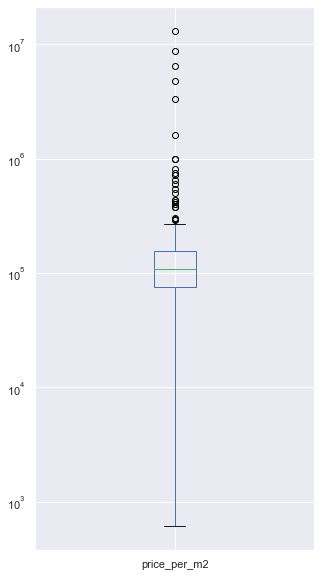

In [194]:
df2['price_per_m2'].plot.box(logy=True, figsize=(5, 10))

In [13]:
df2['price_per_m2'].quantile(0.25)

75798.59000000001

In [12]:
df2['price_per_m2'].quantile(0.75)

154691.00000000003

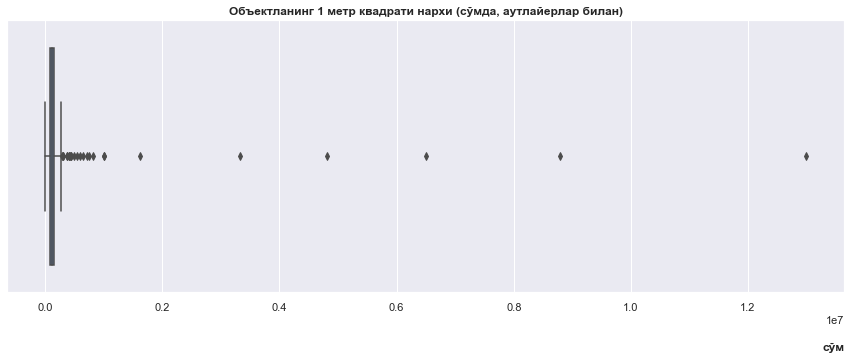

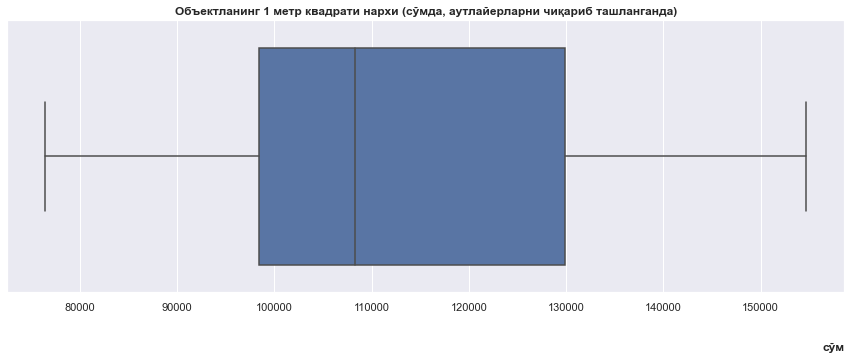

In [203]:
sns.set(rc={'figure.figsize':(15, 5)})
ax = sns.boxplot(x = df2['price_per_m2'])
ax.set_xlabel('сўм', labelpad=30, loc='right', fontweight='bold')
ax.set_title('Объектланинг 1 метр квадрати нархи (сўмда, аутлайерлар билан)', fontweight='bold')
plt.show()
ax = sns.boxplot(x = df3['price_per_m2'])
ax.set_xlabel('сўм', labelpad=30, loc='right', fontweight='bold')
ax.set_title('Объектланинг 1 метр квадрати нархи (сўмда, аутлайерларни чиқариб ташланганда)', fontweight='bold')
plt.show()

In [162]:
df_mean_per_type3

,type,price_per_m2_per_type
1,Базы отдыха,111802.156483
2,Помещения промышленного назначения,112649.091983
3,Склады,112821.900064
4,Помещения свободного назначения,113093.917730
5,Отдельно стоящие здания,113165.794256
6,Часть здания,113368.944510
7,Салоны,113398.999799
8,Офисы,113429.383387
9,Магазины/бутики,113506.905143
10,Рестораны/кафе/бары,113623.039328


In [141]:
df_mean_per_type2.index[-1]

10

In [146]:
df_mean_per_type.loc[df_mean_per_type.type == 'Другое']

,type,price_per_m2_per_type
11,Другое,115048.909517


In [236]:
df_mean_per_type3['price_per_m2_per_type_rounded'] = df_mean_per_type3['price_per_m2_per_type'].apply(lambda x: round(x/1000, 1))

In [237]:
df_mean_per_type3

,type,price_per_m2_per_type,price_per_m2_per_type_rounded
1,Базы отдыха,111802.156483,111.8
2,Помещения промышленного назначения,112649.091983,112.6
3,Склады,112821.900064,112.8
4,Помещения свободного назначения,113093.917730,113.1
5,Отдельно стоящие здания,113165.794256,113.2
6,Часть здания,113368.944510,113.4
7,Салоны,113398.999799,113.4
8,Офисы,113429.383387,113.4
9,Магазины/бутики,113506.905143,113.5
10,Рестораны/кафе/бары,113623.039328,113.6


In [142]:

df_mean_per_type.loc[df_mean_per_type.type == 'Другое']

,type,price_per_m2_per_type
11,Другое,115048.909517


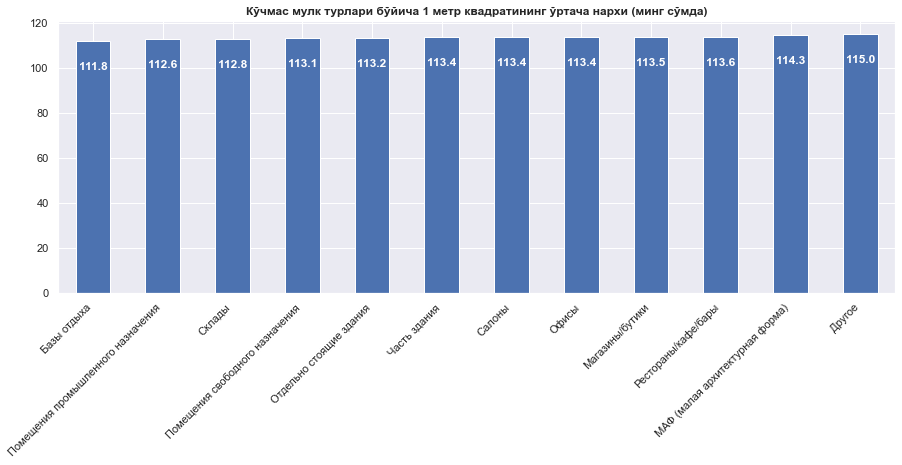

In [261]:
ax = df_mean_per_type3['price_per_m2_per_type_rounded'].plot.bar()
ax.set_xticklabels(labels=df_mean_per_type3['type'], rotation=45, ha='right')
ax.set_title('Кўчмас мулк турлари бўйича 1 метр квадратининг ўртача нархи (минг сўмда)', fontweight='bold')
for i, patch in enumerate(ax.patches):
    x, y = patch.get_xy()
    x += patch.get_width() / 2
    y += patch.get_height()*0.9
    ax.annotate(df_mean_per_type3['price_per_m2_per_type_rounded'][i+1], (x, y), ha='center', va='center', c='white', fontweight='bold')

 1/1:
import re, urllib, urllib2

class Spreadsheet(object):
    def __init__(self, key):
        super(Spreadsheet, self).__init__()
        self.key = key

class Client(object):
    def __init__(self, email, password):
        super(Client, self).__init__()
        self.email = email
        self.password = password

    def _get_auth_token(self, email, password, source, service):
        url = "https://www.google.com/accounts/ClientLogin"
        params = {
            "Email": cbu.research.survey@gmail.com, "Passwd": realsector888$$$,
            "service": service,
            "accountType": "HOSTED_OR_GOOGLE",
            "source": source
        }
        req = urllib2.Request(url, urllib.urlencode(params))
        return re.findall(r"Auth=(.*)", urllib2.urlopen(req).read())[0]

    def get_auth_token(self):
        source = type(self).__name__
        return self._get_auth_token(self.email, self.password, source, service="wise")

    def download(self, spreadsheet, gid=0, forma
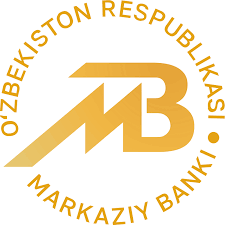

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



351/6:
cols = ['Юрид/Физ. лицо(заемщик)', 'Паспорт/ИНН заемщика', 'Валюта договора', 
        'Сумма Срочной ссудной задолженность', 'Сумма Просроченной ссудной задолженность', 
        'Суммапересмотренной задолженность', 'Сумма В процессе судебного разбирательства', 
        'Сумма Начисленных процентов или дисконт', 'Суммаоплаченогопроцента', 'Вид кредита']

df_list = []
for i in lst:
    lst2 = os.listdir('D:/Portfel/Extracted/Payment to Income/2021/' + i)
    for j in lst2:
        df = pd.read_excel('D:/Portfel/Extracted/Payment to Income/2021/' + i +  '/' + j, engine='pyxlsb')
        ind_values = df[df[df.columns[0]].str.contains('Юрид/Физ').fillna(False)].index.values
        #print(ind_values)
        #if len(ind_values) > 1:
         #   ind = ind_values[len(ind_values) - 1]
        #else:
         #   ind = ind_values
        df.drop(np.arange(ind_values+4), inplace=True)
        df.reset_index(drop=True, inplace=True)
        df.columns = cols
        df['Ой'] = i
        

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [6]:
while True:
    print('Oybek')
    time.sleep(10)

Oybek
Oybek
Oybek
Oybek
Oybek


KeyboardInterrupt: 

In [41]:
import pandas as pd
import time
aaa=pd.DataFrame(columns=['ism', 'sharif'])
bbb=pd.DataFrame([['Oybek', 'Ruziboev']], columns=['ism', 'sharif'])
aaa = pd.concat([aaa, bbb])
aaa.to_csv('Oybek', index=False)
while True:
    aaa = pd.read_csv('Oybek')
    aaa = pd.concat([aaa, bbb])
    aaa.reset_index(drop=True, inplace=True)
    aaa.to_csv('Oybek', index=False)
    time.sleep(2)

In [43]:
aaa

,ism,sharif
0,Oybek,Ruziboev


KeyboardInterrupt: 

In [46]:
aaa

,ism,sharif
0,Oybek,Ruziboev
1,Oybek,Ruziboev
2,Oybek,Ruziboev
3,Oybek,Ruziboev
4,Oybek,Ruziboev
5,Oybek,Ruziboev
6,Oybek,Ruziboev
